In [5]:
# DATA
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import gc

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

le = LabelEncoder()

def feature_engineering(df):  
    all_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    categorical_cols = ['Sex']
    
    for c in categorical_cols:
        df[c] = le.fit_transform(df[c]) # Converts categorical column into int format
        df[c] = df[c].astype('category') # Define column type as category 

    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['Intensity'] = df['Heart_Rate'] / df['Duration']
    
    # Adding combinations of categorical cols as columns
    gc.collect()
    
            
    return df


test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

labels = train_df['Calories']
train_df.drop('Calories',axis=1,inplace=True)

train_df.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,24.374817,10.547400
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,1.511310,12.237710
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,12.375937,2.714286
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,23.255019,4.521739
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,24.391059,6.214286
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,25.487697,10.750000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,46.443986,108.000000


In [6]:
import xgboost as xgb

first_model = xgb.XGBRegressor()
first_model.load_model("models/XGB_first.json")

second_model = xgb.XGBRegressor()
second_model.load_model("models/XGB_second.json")

third_model = xgb.XGBRegressor()
third_model.load_model("models/linear_model.json")


In [7]:
#preds1 = first_model.predict(test_df.drop("id",axis=1))
#preds2 = second_model.predict(test_df.drop("id",axis=1))
#ids = test_df["id"]

preds1 = first_model.predict(test_df.drop("id",axis=1))
preds2 = second_model.predict(test_df.drop("id",axis=1))
preds3 = third_model.predict(test_df.drop(["id","BMI",'Age','Height','Weight',"Intensity","Sex"],axis=1))


ids = test_df["id"]

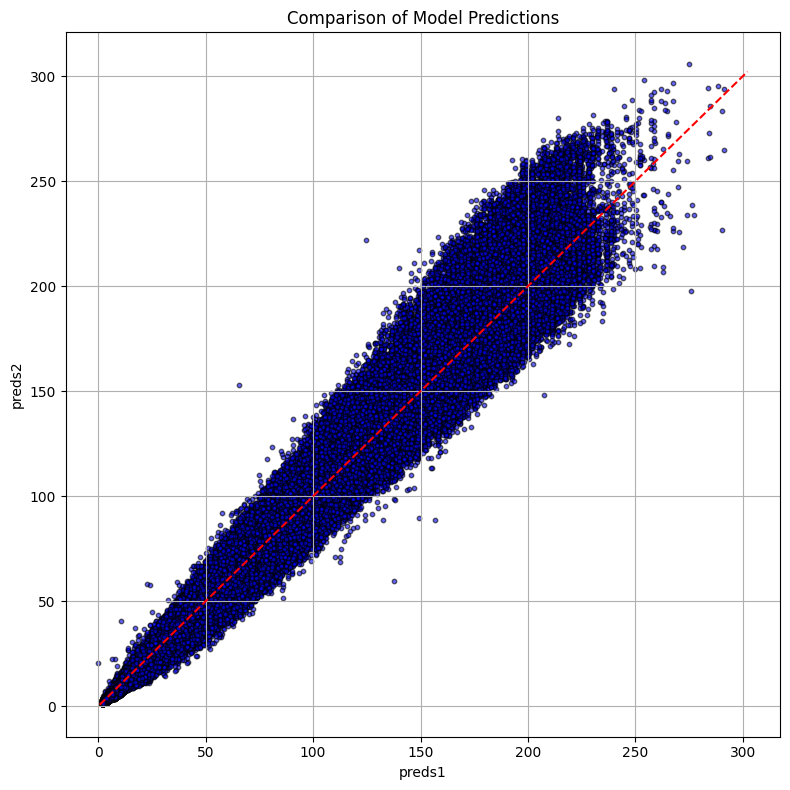

In [11]:
pred_frame = pd.DataFrame()

pred_frame["preds1"] = preds1
pred_frame["preds2"] = preds2
pred_frame["preds3"] = preds3
pred_frame["ids"] = ids

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(pred_frame["preds3"], pred_frame["preds2"], s=10, alpha=0.6, c='blue', edgecolors='k')
plt.plot([min(preds1), max(preds1)], [min(preds1), max(preds1)], color='red', linestyle='--')  # y = x line
plt.title("Comparison of Model Predictions")
plt.xlabel("preds1")
plt.ylabel("preds2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np

preds1 = np.maximum(preds1, 0)
preds2 = np.maximum(preds2, 0)
preds3 = np.maximum(preds3, 0)


pred1_weighted = np.log1p(preds1)*0.4200
pred2_weighted = np.log1p(preds2)*0.4800
pred3_weighted = np.log1p(preds3)*0.1000


ensemble_preds = np.expm1(pred1_weighted + pred2_weighted + pred3_weighted)

submission = pd.DataFrame({"id": test_df["id"], "prediction": ensemble_preds})

submission.to_csv("submission.csv", index=False)
